## Boosting and Stacking

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

In [2]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

In [3]:
data.shape

(10299, 562)

In [4]:
data.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [8]:
# Mask to select float columns
float_cols = (data.dtypes == np.float64)
print((data.loc[:,float_cols].max()==1.0).all())
print((data.loc[:,float_cols].min()==0.0).all())

True
False


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Activity'] = le.fit_transform(data['Activity'])
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split
feature_cols = [x for x in data.columns if x != 'Activity']
X_train,X_test,y_train,y_test = train_test_split(data[feature_cols], data['Activity'], test_size = 0.3, random_state =42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7209, 561), (3090, 561), (7209,), (3090,))

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:

    GBC = GradientBoostingClassifier(n_estimators = n_trees, random_state=42)

    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values,y_train.values)
    y_pred =  GBC.predict(X_test)

    error = 1.0 - accuracy_score(y_test,y_pred)
    error_list.append(pd.Series ({'n_trees' : n_trees, 'error' : error}))

error_df = pd.concat(error_list, axis = 1).T.set_index('n_trees')
error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


,error
n_trees,
15.0,0.051133
25.0,0.034304
50.0,0.019741
100.0,0.012945
200.0,0.011650
400.0,0.011650


(0.0, 440.00000000000006)

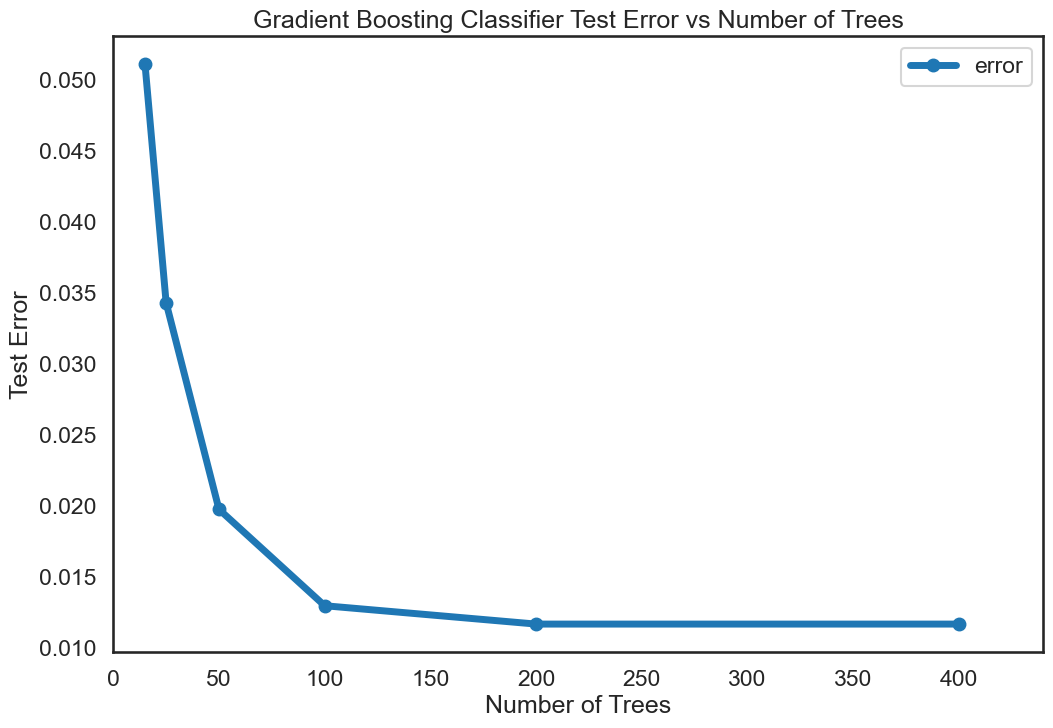

In [16]:
sns.set_context('talk')
sns.set_style('white')

ax = error_df.plot(marker = 'o', figsize = (12,8), linewidth =5)

ax.set(xlabel = 'Number of Trees', ylabel = 'Test Error', title = 'Gradient Boosting Classifier Test Error vs Number of Trees')
ax.set_xlim(0, max(error_df.index)*1.1)

In [17]:
from sklearn.model_selection import GridSearchCV
param_grid= { 'n_estimators': tree_list,
              'learning_rate':[0.1,0.01,0.001,0.0001],
              'subsample':[1.0,0.5],
              'max_features': [1,2,3,4]}

GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [18]:
GV_GBC.best_estimator_

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,400
,subsample,0.5
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred,  y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.97      0.97       559
           2       0.97      0.97      0.97       549
           3       1.00      1.00      1.00       539
           4       0.99      1.00      0.99       419
           5       0.99      0.99      0.99       427

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



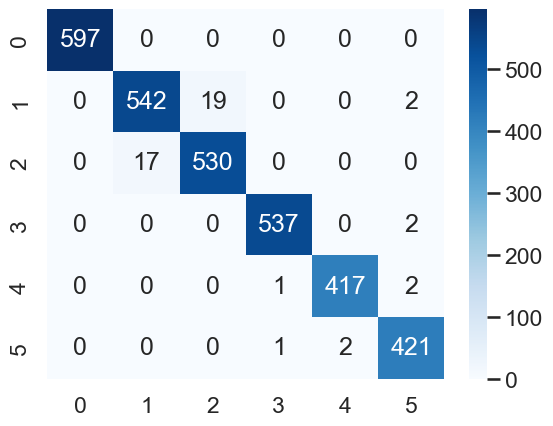

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## Create an Adaboost model and fit it using grid search

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

In [23]:
GV_ABC.best_estimator_

,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,100
,learning_rate,0.01
,algorithm,'deprecated'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [24]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.00      0.00      0.00         0
           2       1.00      0.49      0.66      1109
           3       1.00      0.39      0.56      1384
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.54      3090
   macro avg       0.50      0.31      0.37      3090
weighted avg       1.00      0.54      0.68      3090



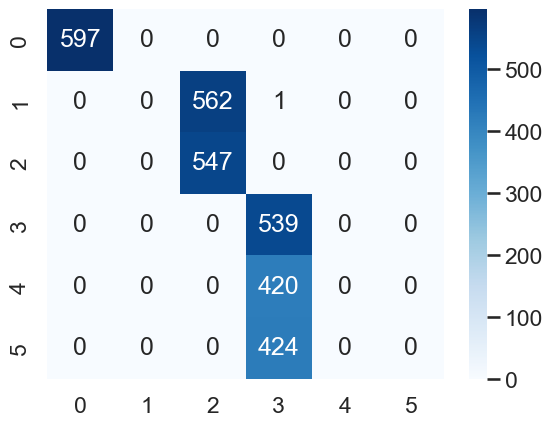

In [25]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

## Using VotingClassifier, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model

In [26]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

In [27]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       598
           1       0.95      0.96      0.95       558
           2       0.95      0.95      0.95       547
           3       1.00      0.99      0.99       544
           4       0.98      1.00      0.99       413
           5       1.00      0.98      0.99       430

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



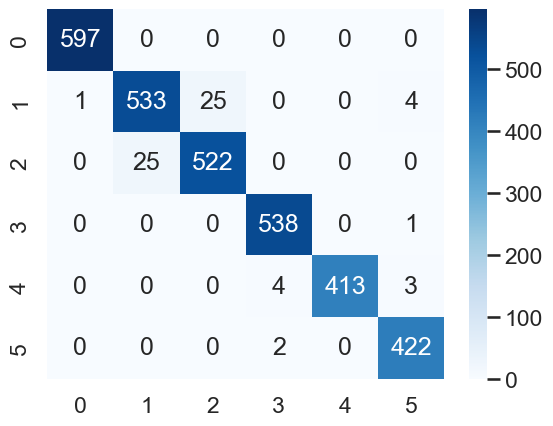

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

In [29]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

In [30]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.97       563
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      1.00      1.00       420
           5       0.99      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



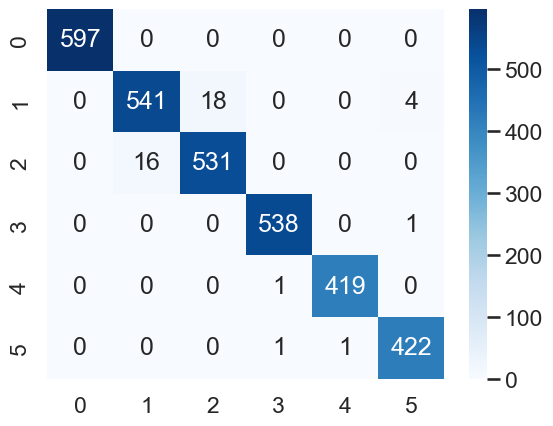

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()